<a href="https://colab.research.google.com/github/paascorb/ClasificacionBillar/blob/main/TrabajoPID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Procesamiento de imágenes digitales

En este trabajo vamos a tratar de contar y detectar las bolas de billar en una disposición dada. Para obtener la imagen me he metido en un campeonato de billar de 2022, y cuando se ha visto la mesa desde arriba la he capturado.

El vídeo que comento es el siguiente:
https://youtu.be/1FJG2Tg2bDQ?list=LL&t=3599


Primero vamos a cargar la imagen con OpenCV

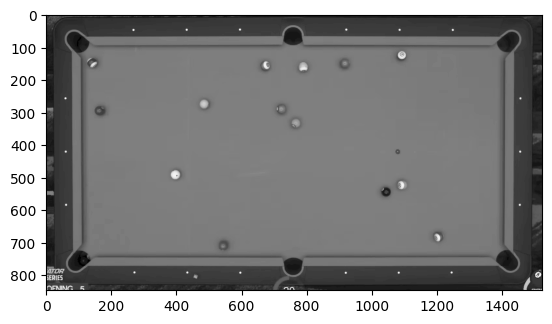

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def mostrarImagen(imagen):
    if len(imagen.shape)==3:
        img2= cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        plt.imshow(img2)
        plt.show()
    else:
        plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)
        plt.show()

# Imagen disponible en el aula virtual
img = cv2.imread('billar.png', 0)
mostrarImagen(img)

Como vemos, tenemos varias bolas en la mesa y nuestra intención inicialmente es detectarlas y contarlas, posteriomente trataremos de clasificarlas.

## Detección y conteo

La primera aproximación es calcular la transformada de Hough para detectar los círculos.

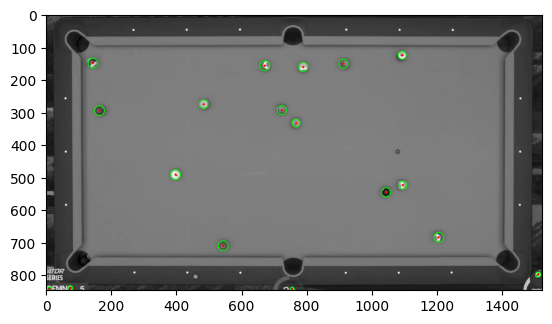

In [65]:
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT, dp=1,
                           param1=50,param2=20,
                           minDist=50, minRadius=5, maxRadius=20)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

mostrarImagen(cimg)

Tras reajustar un poco los parámetros, nos detecta perfectamente las pelotas, solo que también algunos otros círculos, vamos a reajustarlo algo más.

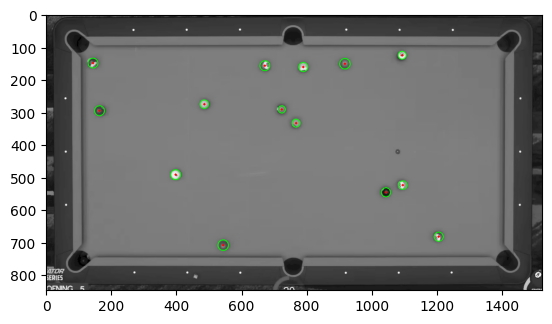

In [73]:
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT, dp=1,
                           param1=50,param2=20,
                           minDist=40, minRadius=10, maxRadius=20)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

mostrarImagen(cimg)

Hecho, ahora contamos los círculos.

In [75]:
len(circles[0,:])

14

Vemos que tenemos un total de 14 bolas en la mesa. Vamos a tratar de asignarles las etiquetas.

In [76]:
circles

array([[[ 486,  276,   13],
        [ 398,  492,   15],
        [ 790,  162,   14],
        [ 918,  152,   16],
        [1044,  546,   14],
        [ 672,  158,   15],
        [ 164,  296,   15],
        [1094,  126,   12],
        [ 144,  150,   15],
        [ 544,  708,   16],
        [ 768,  334,   12],
        [1206,  682,   14],
        [1096,  524,   13],
        [ 724,  292,   11]]], dtype=uint16)

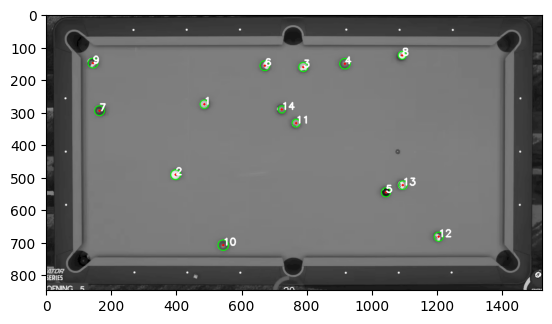

In [127]:
result = cimg.copy()

for count, c in enumerate(circles[0,:]):
    x = c[0]
    y = c[1]
    cv2.putText(result, str(count+1), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

mostrarImagen(result)

Perfecto, para continuar, queremos detectar la bola negra y la bola blanca.

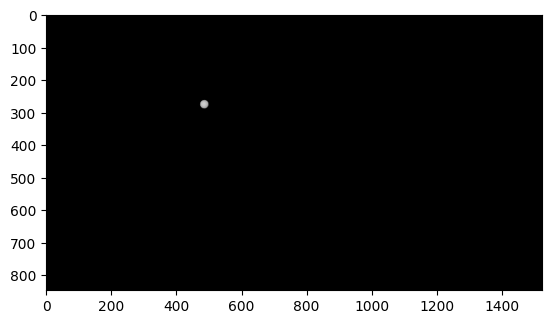

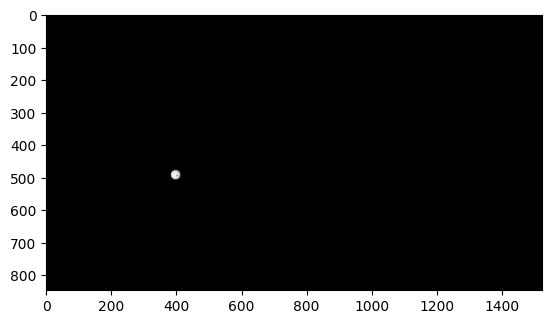

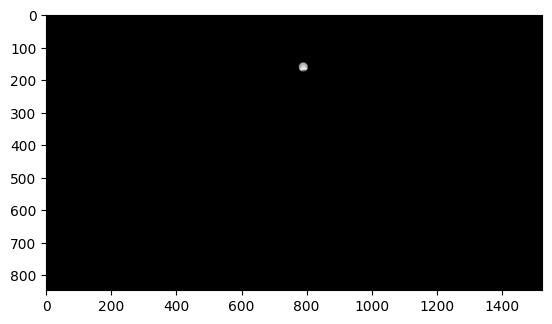

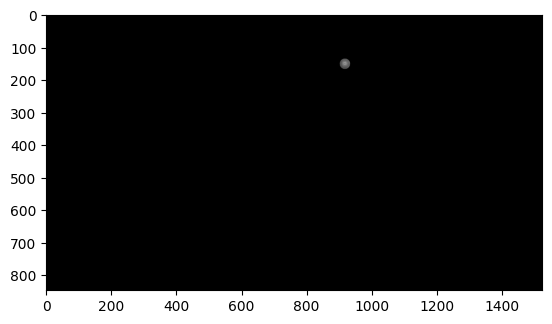

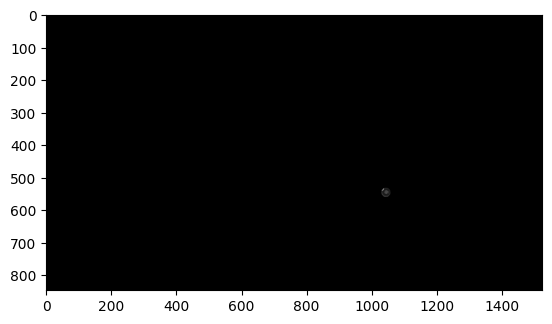

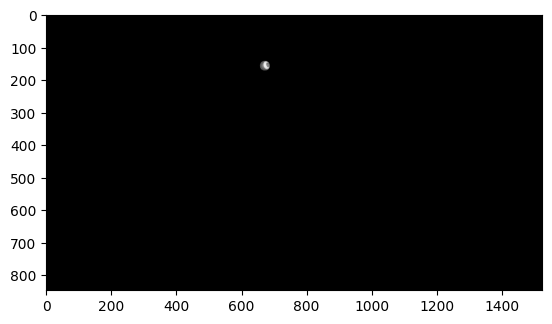

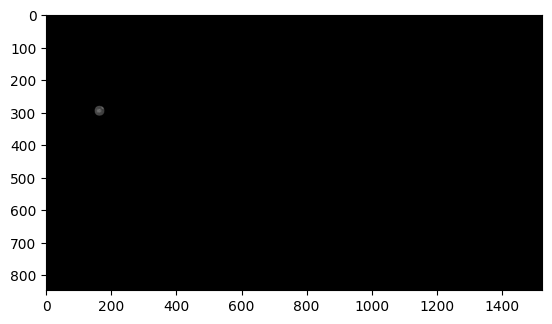

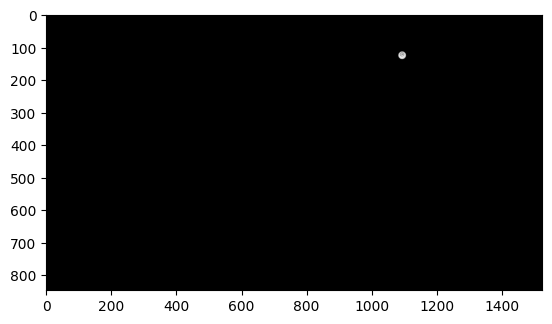

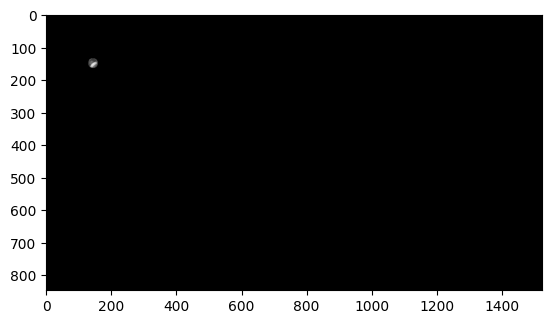

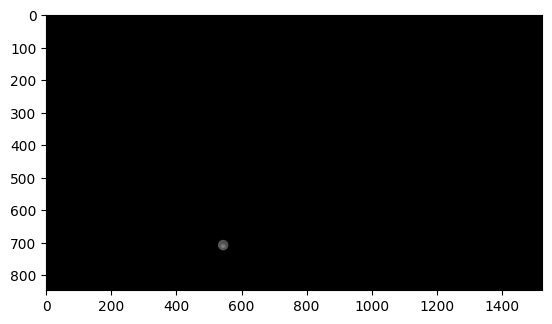

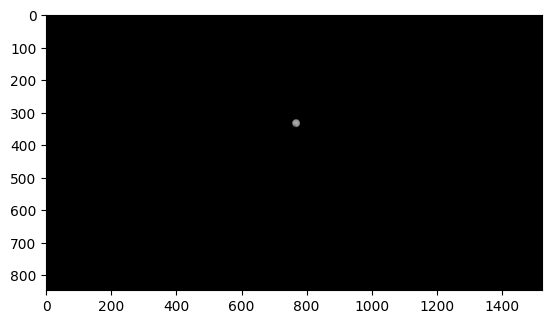

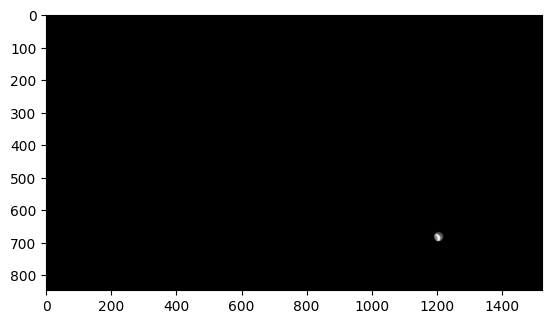

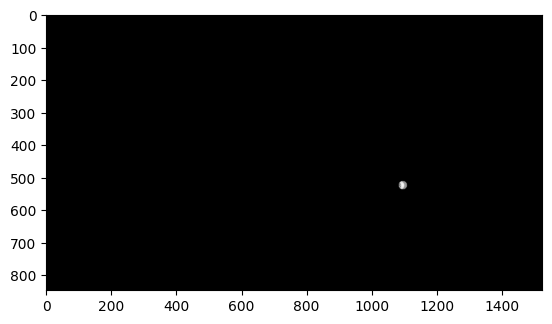

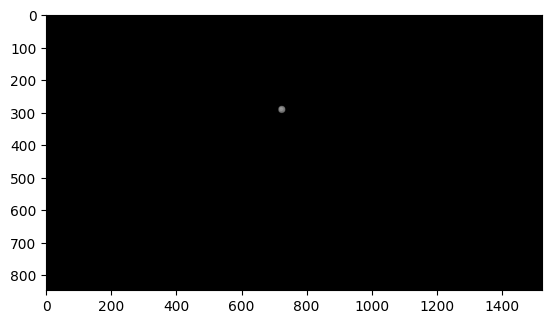

In [90]:
bolas = []

for c in circles[0,:]:
  aux = img.copy()
  mask = np.zeros_like(img)
  mask = cv2.circle(mask, (c[0], c[1]), c[2], (255,255,255), -1)
  aux = cv2.bitwise_and(aux, mask)
  bolas.append(aux)

for bola in bolas:
  mostrarImagen(bola)

Tenemos las bolas por separado, ahora lo que queremos es contar el número de píxesles blancos de cada una y la que más tenga será la blanca. Para poder contar bien los píxeles blancos o umbralizamos o contamos píxeles muy claritos, no solo los blancos.

In [97]:
blancos = []
for i, bola in enumerate(bolas):
  blancos.append((np.sum(bola >= 225), i))

max(blancos, key=lambda item: item[0])

(278, 1)

Ahora comprobamos que sea la blanca.

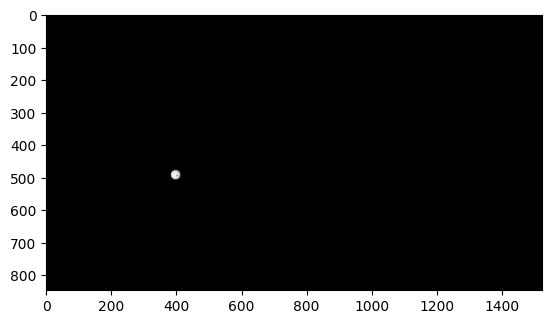

In [98]:
mostrarImagen(bolas[1])

In [108]:
blanca = max(blancos, key=lambda item: item[0])[1]

Efectivamente; hacemos lo mismo para la bola negra.

In [116]:
negros = []
for i, bola in enumerate(bolas):
  negros.append((np.sum(bola <= 50), i))

max(negros, key=lambda item: item[0])

(1289127, 4)

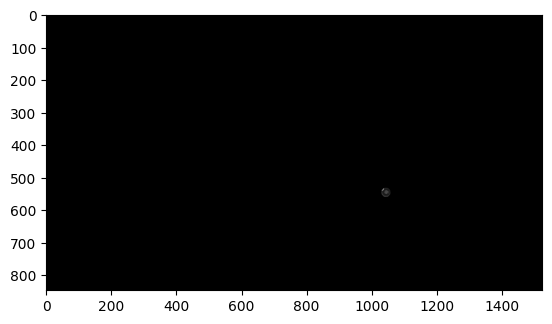

In [105]:
mostrarImagen(bolas[4])

In [114]:
negra = max(negros, key=lambda item: item[0])[1]

Ahora vamos a diferenciar entre las rayadas y las lisas. Realmente es bastante sencillo, ya que, de nuevo, vamos a contar píxeles claros y oscuros.

In [131]:
rayadas = []
lisas = []
for i, bola in enumerate(bolas):
  if i != negra and i != blanca:
    if np.sum(bola >= 225) != 0: 
      rayadas.append(i)
    else:
      lisas.append(i)

Teniendo esto, simplemente asignamos las etiquetas:


*   B = Blanca
*   N = Negra
*   R = Rayada
*   L = Lisa



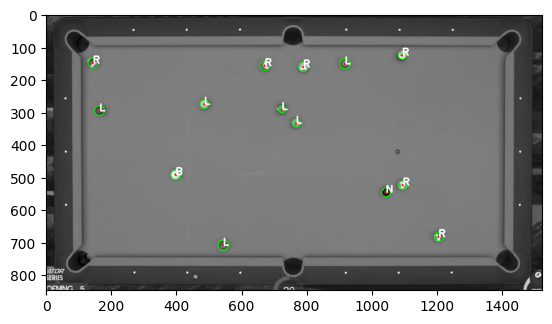

In [132]:
result = cimg.copy()

for count, c in enumerate(circles[0,:]):
    x = c[0]
    y = c[1]
    if count == blanca:
      et = 'B'
    elif count == negra:
      et = 'N'
    elif count in rayadas:
      et = 'R'
    else:
      et = 'L'
    cv2.putText(result, et, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

mostrarImagen(result)

In [133]:
cv2.imwrite("resultado.png", result)

True

Et voilá, hemos calculado para cada bola su posición y a qué clase pertenece.
Esto realmente está muy "manual" porque los umbrales de píxeles los he decidido yo a ojo. Pero se podría automatizar perfectamente.